# Robust Facility Location Problem

In this demo, we will consider the problem of robust facility location, based on some (uncertain) projections about demand. 
Let's consider the following, where we plan to pick a subset of 10 facility locations with indices $i \in I$ to service 50 customers with indices $j \in J$. 
Each facility has a capacity $s_i$, and a construction cost of $f_i$. 
The transportation costs $c_{i,j}$ are defined across each facility-customer pair $\{i, j\}$, and are variable depending on the quantity of goods moved. 

We begin by launching a Julia environment, adding some packages and plotting utilities, and generating some random (but interesting) data. 

In [ ]:
# Packages
using Pkg
Pkg.activate(".")

using JuMP, GLPK, Random, LinearAlgebra, DataFrames, PyPlot
include("utils.jl")

optimizer = optimizer_with_attributes(GLPK.Optimizer)

n = 10 # Number of facilities
m = 50 # Number of customers

# Generating random data (for fixed random seed)
facilities = 0.6.*rand(MersenneTwister(5), n,2) .+ 0.2;
customers = rand(MersenneTwister(2), m, 2); 
c = [LinearAlgebra.norm(customers[i, :] .- facilities[j, :])[1] for j=1:n, i=1:m];
f = rand(MersenneTwister(3), n)*1 .+ 5;
s = rand(MersenneTwister(4), n)*2 .+ 15;
d = rand(MersenneTwister(5), m)*0.5 .+ 0.75;

At first, we will assume that the demand $d_j$ at each demand node is fixed and deterministic. This we call the nominal problem, stored in `nominal.jl`, which we can optimize to see the nominal facility locations under perfect knowledge. 

In [ ]:
include("nominal.jl")
model, x, y = facility_model(c, f)
optimize!(model)
plt = plot_solution(model, x, y)
show()

However, the real world is not so straightforward. In reality, we expect some demand uncertainty, which we model as $d_j + (Pz)_j$, where $d_j$ is the nominal demand, and the $(Pz)_j$ is the demand perturbation at node $j$. $z_j$ describes a demand perturbation at any node $j$, which affects all nearby nodes through the $P$ matrix. The $P \in \mathbb{R}^{m \times m}$ matrix describes how the demand perturbation at a node $j$ dissipates exponentially with the inverse of the distance, i.e. $\frac{1}{5} e^{d_{i,j}^{-1}}$, up to a Euclidian distance of $R_D = 0.25$. **In jargon, we define a polyhedral uncertainty set through a truncated exponential kernel.**


In [ ]:
R_D = 0.25
P = [0.2*exp(-1/R_D .*LinearAlgebra.norm(customers[i, :] .- customers[j, :])[1]) for j=1:m, i=1:m];
P = (P .>= 0.2*exp(-1/R_D .* R_D)) .* P
first(DataFrame(P, :auto), 5)

We will assume that the uncertain parameters $z$ come from within a budget uncertainty set, $||z||_{\infty} \leq \rho,~ ||z||_{1} \leq \Gamma$. The robust counterpart of the facility location problem can be found in `robust.jl`. For now, we will optimize the facility locations considering *static* transportation decisions, for $\rho = 1$ and $\Gamma = 5$. 

In [ ]:
ρ = 1
Γ = 5
println("Total nominal demand: $(round(sum(d), digits=2))")
println("Potential maximum demand perturbation under budget set: $(round(sum(sort([sum(P[i,:]) for i=1:size(P)[1]])[end-Int32(floor(Γ)):end]), digits=2))")

This means that the uncertainty could cause up to 14% unmet demand. 

In [ ]:
# Robust model (3.2)
include("robust.jl")
model, x, y = robust_facility_model(c, f, ρ, Γ)
optimize!(model)
plt = plot_solution(model, x, y)
show()

As you can see, the uncertainty resulting in us building two more facilities, and also increasing our transportation cost by over 30%.

We can do a more in depth analysis of the **stability** of optimal facility locations by keeping the maximal demand perturbation $\rho$ constant, but changing the size of $\Gamma$ and reoptimizing. Running the cell below will allow us to compare the relative numbers and locations of our facilities as we change the size of our uncertainty set.  

In [ ]:
Γs = collect(0:8)
df = DataFrame("Gamma" => [], "f+c" => [], "f" => [], "c" => [], "nx" => [])
fig = figure("3x3_subplot", figsize = (15, 15))
ps = []
for k = 1:length(Γs)
    Γ = Γs[k]
    model, x, y = robust_facility_model(c, f, ρ, Γ)
    println("Gamma = $(Γ)")
    optimize!(model)
    push!(df, Dict("Gamma" => Γ,
                     "f+c" => objective_value(model),   
                     "f" => value(sum(f[j] * x[j] for j = 1:n)),
                     "c" => value(sum(c[i, j] * y[i, j] for i=1:n, j=1:m)),
                     "nx" => sum(value.(x))))
    subplot(330 + k)
    push!(ps, plot_solution(model, x, y))
    println()
    title("Total cost for Γ = $(Γ): $(round(objective_value(model), sigdigits=5))")
end

**There are four stable sets of facility locations** as we increase the overall size of the uncertainty that $\Gamma$. We can also take a better look at the results by observing the table created in the for loop, which shows the magnitudes of the facility and transportation costs, as well as the number of facilities as we change $\Gamma$. This can be see by the constant fixed cost $f$ as shown in the table below. 

In [ ]:
df

# How about doing Adaptive Robust Optimization? 

The facility location problem is amenable to *adaptive*, i.e. *two-stage* solutions, where actions can occur before or after the uncertainty realized. In this case, the facility location selections will occur *before* the uncertain demand is realized, and the actual demand will be satisfied *after* the uncertain demand is realized. 

$$ \underset{x, y(.)}{\mathrm{min}} \{ c \cdot x: A(z)x + B(z) y(z) \leq B, \forall z \in Z\} 
$$

In this case we are going to consider *affine adaptivity*, where the second stage decisions $y$ are going to be an affine function of the uncertain outcomes!

$$y(z) = u + Vz$$. 

In [ ]:
include("adaptive.jl")

In [ ]:
optimizer = optimizer_with_attributes(GLPK.Optimizer)
# Adaptive model through robust counterpart
rho = 1
Gamm = 5
model, x, u, V = adaptive_facility_model(c, f, rho, Gamm, optimizer)
set_attribute(model, "msg_lev", GLPK.GLP_MSG_ON)
@time optimize!(model)
plt = plot_solution(model, x, u)
@show plt

There is unfortunately not enough time to solve this problem in real time, so the solution will have to suffice! Also, recall that the cost of the static robust solution was 50.579, thus **adaptivity saves us 38% in cost compared to the static robust solution, and is only 8% more expensive than the nominal solution!**

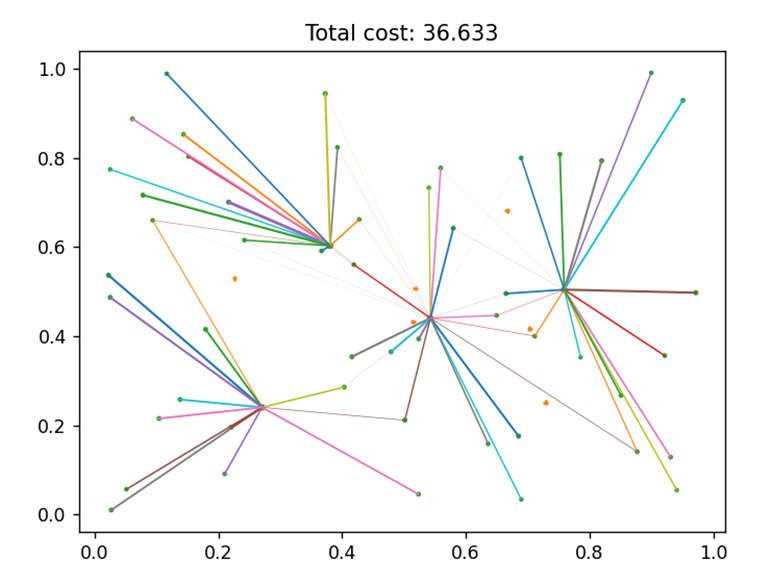

# Adaptive Robust Optimization via Cutting Planes

Remember that it is possible to do robust optimization without deriving the robust counterpart!!

In [ ]:
include("cuts.jl")

In [ ]:
rho = 1
Gamm = 5
model, x, u, V = CP_facility_model(c, f, optimizer)
apply_heuristic(model, x, u, V) # Just ensures u and V are positive w.r.t the uncertainty, just for the first iteration.
optimize!(model)
fig = figure("1x3_subplot", figsize = (15, 5))
subplot(121)
xvals, uvals, Vvals = value.(x), value.(u), value.(V)
plot_solution(model, xvals, uvals)
title("Iteration 0: $(round(objective_value(model), digits=2))")

# Just do 20 iterations for demo purposes. 
costs = []
for i=1:20
    @info("Iteration $(i).")
    xvals, uvals, Vvals = value.(x), value.(u), value.(V)
    cut_count, model = find_wc_cuts(model, x, u, V, xvals, uvals, Vvals , rho, Gamm, optimizer)
    if cut_count == 0
        @info("CONVERGED.")
        @info("Optimal cost: $(objective_value(model)).")
        break
    end
    optimize!(model)
    @info("Optimal cost: $(round(objective_value(model), digits=2)).")
    @info("")
    append!(costs, round(objective_value(model), digits=2))
end
subplot(122)
xvals, uvals, Vvals = value.(x), value.(u), value.(V)
plot_solution(model, xvals, uvals)
title("Iteration 20: $(round(objective_value(model), digits=2))")

# Problem should converge in <100 adversarial iterations. 

In [ ]:
plot(costs)
plot(0:20, 2.6*ones(21), color="red")
xlabel("Iteration number")
ylabel("Costs")
ylim(22, 30)